In [1]:
# Global Variables
debug = True                        # Displays additional logging output
savePlots = False                   # Saves plot image files
targetColumnName = "TARGET"         # Name for column denoting dependant variable
outlierThreshold = 3                # Number of standard deviations from which data will be classified as an outlier
dropMissingValues = True #Needs to be true for randomTreeRegressor

# Various file names for debugging and analysis
stringVariablesFile =           './outputFiles/stringVariables.txt'
continuousVariablesFile =       './outputFiles/continuousVariables.txt'
categoricalVariablesFile =      './outputFiles/categoricalVariables.txt'
datasetName =                   './dataset/application_train.csv'
initialDataFileName =           './outputFiles/initialData.txt'
missingValFileName =            './outputFiles/missingValueSummary.txt'
noMissingValuesFileName =       './outputFiles/noMissingValueSummary.txt'
initialDistributionFileName =   './outputFiles/initialDistribution.txt'
dataFrameFileName =             './outputFiles/dataFrameDebug.txt'
generalDebugFileName =          './debug.txt'
testFileName =                  './dataset/application_test.csv'

# Chosen top 10 variables from ASG1
# @TODO: figure out if we want to do a mixture of ext source variables
# @todo: figure out if we want to remove target from these columns
chosenTopTenVariables = ['TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'CODE_GENDER', 'EXT_SOURCE_1',
                         'DAYS_BIRTH', 'CNT_CHILDREN', 'AMT_CREDIT', 'NAME_INCOME_TYPE',
                         'NAME_EDUCATION_TYPE']

forestTopTenVariables = ['EXT_SOURCE_3',
                         'TARGET',
'EXT_SOURCE_2',
'EXT_SOURCE_1',
'AMT_ANNUITY',
'DAYS_EMPLOYED',
'AMT_CREDIT',
'DAYS_ID_PUBLISH',
'DAYS_REGISTRATION',
'LIVINGAREA_MODE',
'AMT_GOODS_PRICE',
]
#, 'ORGANIZATION_TYPE'*/]

lineString = "---------------------------------------------------------------------------------------------------------"

debugFd = open(generalDebugFileName, "w+")

if debug == True:
    debugFd.write("Global Variables Cell Completed...\n")
    debugFd.write(lineString+"\n")

In [2]:
# Library Imports
from nis import cat
from re import X
import pandas as pd                 # Used for data frame
import plotly                       # Saves html plots
import plotly.express as px         # Used for displaying plots
import os                           # Allows file manipulation and console debugging for offline jupyter
import numpy as np
from scipy import stats             # Used for outliers
import matplotlib.pyplot as plt     # Used for pyplot heatmap plotting
import seaborn as sns               # Used for showing heatmap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import linear_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
    # Import the model we are using
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from sklearn.ensemble import RandomForestRegressor
#@TODO: Figure out if we want to delete this or not and use the sklearn tree
from sklearn import tree
from sklearn.datasets import load_iris
import graphviz # Data Tree Visualization

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
import pickle                                   # Saving Models
from sklearn.ensemble import RandomForestClassifier

import graphviz # Data Tree Visualization
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
import pydot

import phik

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

if debug == True:
    print("Library Imports Cell Completed...")
    print(lineString)

Library Imports Cell Completed...
---------------------------------------------------------------------------------------------------------


In [3]:
# Module Imports

if debug == True:
    debugFd.write("Module Imports Cell Completed...\n")
    debugFd.write(lineString+"\n")

In [4]:
# Software configurations
pd.options.display.max_rows = 4000  # Allows better debugging analysis

if debug == True:
    debugFd.write("Software Configuration Cell Completed...\n")
    debugFd.write(lineString+"\n")

In [5]:
# Helper Functions

# If the debugging flag is on, creates directories to store output data
#
# Parameters:
# -----------
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# None
#
def createOutputDirectories(debug = False):
    if debug == False:
        return
    if not os.path.exists("images"):
        os.mkdir("images")
    if not os.path.exists("images/initialPlots"):
        os.mkdir("images/initialPlots")
    if not os.path.exists("images/topTenPlots"):
        os.mkdir("images/topTenPlots")
    if not os.path.exists("outputFiles"):
        os.mkdir("outputFiles")
    print("createOutputDirectories...success")


# Reads csv file into data frame and sets independant and dependant variables
#
# Parameters:
# -----------
# @param fileName: string for full relative file path of csv file
# @param dependantVarColumnName: csv file column matching name of column for dependant variable
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# data: dataframe object of csv file reading
# independantVars: independant variables (all data that isn't targetColumnName)
# dependantVar: dependant variable
#
def readData(fileName, dependantVarColumnName = targetColumnName, debug = False):
    independantVars = []
    dependantVar = []
    data = pd.read_csv(fileName)
    index = None
    for i ,col in enumerate(data.columns):
        if col == dependantVarColumnName:
            index = i
    if index != None: 
        dependantVar = data.iloc[:, index]
        independantVars = data.iloc[:]
        independantVars.pop(dependantVarColumnName)
    if debug:
        fd = open(initialDataFileName, "w+")
        fd.write("This file contains the initial data frame without cleaning:\n")
        fd.write(str(data))
        fd.close()
        print("readData...completed")
    return data, independantVars, dependantVar


# Drops rows from dataset which are missing. Prints missing value data for debugging
#
# Parameters:
# -----------
# @param data: dataframe to have missing values dropped and returned
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# data: dataframe object with missing values dropped
#
def dropMissingValues(data, debug = False):
    # Drop missing values
    ret = data.dropna(axis=0)
    # Show number of missing values per independant variable
    if debug:
        fd = open(missingValFileName, "w+")
        fd.write("This data shows the independant variables which contained missing values and the count of each:\n")
        fd.write(str(data.isnull().sum()))
        fd.close()
        fd = open(noMissingValuesFileName, "w+")
        fd.write("This data shows the independant variables which are used for analysis with no mising values:\n")
        fd.write(str(ret.isnull().sum()))
        fd.close()
        print("dropMissingValues...completed")
    return ret


def setMeanValues(data, debug = False):
    return data

# Writes distribution of data frame to text file
#
# Parameters:
# -----------
# @param data: dataframe to have distribution written to text file
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# None
#
def writeDistribution(data, debug = False):
    if debug == False:
        return
    numpy_array = data.to_numpy()
    fd = open(initialDistributionFileName, "w+")
    fd.write(str(numpy_array))
    fd.close()
    print("writeDistribution...success")


def doBar(data, column_name, figsize = (18,6), 
          percentage_display = True,
          plot_defaulter = True, rotation = 0, 
          horizontal_adjust = 0, 
          fontsize_percent = 'xx-small',
          dirName = 'images/initialPlots/'):

    
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)

    fileName = dirName + column_name + '.png'
    plt.savefig(fileName)


# Plots a column name of the dataframe and saves each plot into a file
#
# Parameters:
# -----------
# @param data:       dataframe to have distribution written to text file
# @param plots:      types of plots for each column to show e.g. "box"
# @param: figsize:   size of figure for matplotlib to plot
# @param: log_scale: flag to log the scale of the plot
#
# Returns:
# ---------
# None
#
def plot_column(data,
                column_name,
                plots = [],
                figsize = (20,8),
                log_scale = False,
                dirName = 'images/initialPlots/'):

    if 'bar' in plots:
        doBar(data, column_name, figsize, dirName = dirName)
        return
    data_to_plot = data.copy()
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, len(plots), i + 1)
        plt.subplots_adjust(wspace=0.25)
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
        elif ele == 'distplot':
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')
        elif ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')
        elif ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    fileName = dirName + column_name + '.png'
    plt.savefig(fileName)


def showTargetPlot(data, debug = False):
    class_dist = data[targetColumnName].value_counts()

    if debug == True:
        print(class_dist)

    plt.figure(figsize=(12,3))
    plt.title('Distribution of TARGET variable')
    plt.barh(class_dist.index, class_dist.values)
    plt.yticks([0, 1])

    for i, value in enumerate(class_dist.values):
        plt.text(value-2000, i, str(value), fontsize=12, color='white',
                 horizontalalignment='right', verticalalignment='center')
    plt.show()


def showHeatmap(data):
    corrmat = data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))
    #plot heat map
    g=sns.heatmap(data[top_corr_features].corr(),cmap="RdYlGn")
    plt.show()


# Allocates data frames for each data type of argument data frame
# @TODO: implement data frame of integer types not being labeled as categorical
#
# Parameters:
# -----------
# @param data:   dataframe to be split into respective types
# @param debug: flag for displaying debugger output of writing columns into respective files
#
# Returns
# ---------
# strTypes           columns of string type
# continuousTypes    columns of continuous variables
# categorical        columns of categorical types
#
def allocateTypes(data, debug = False):
    strTypes = data.select_dtypes(include='object')
    continuousTypes = data.select_dtypes(include = ['float64', 'int64'])
    if debug == True:
        fd = open(stringVariablesFile, "w+")
        fd.write("String-type variables:\n")
        fd.write(lineString)
        for col in strTypes.columns: 
            fd.write(col + "\n")
        fd.close()
        fd = open(continuousVariablesFile, "w+")
        fd.write("Continuous-type variables:\n")
        fd.write(lineString)
        for col in continuousTypes.columns: 
            fd.write(col + "\n")
        fd.close()
        print("allocateTypes...success")
    return strTypes, continuousTypes


# Workaround to insert string into file without overwriting contents
#
# Parameters:
# -----------
# @param originalfile: original file name
# @param string:       string to be written to file
#
# Returns:
# ---------
# None
#
def insert(originalfile,string):
    with open(originalfile,'r') as f:
        with open('newfile.txt','w') as f2: 
            f2.write(string)
            f2.write(f.read())
    os.rename('newfile.txt',originalfile)


# @TODO: figure out a try except for the format of the numpy array printed out
# Prints a data frame
#
# Parameters:
# -----------
# @param data: dataframe to be printed
#
# Returns:
# ---------
# None
#
def printDataFrame(data):
    numpy_array = data.to_numpy()
    numpy_array = [i for i in numpy_array if str(i) != 'nan']
    
    try: np.savetxt(dataFrameFileName, numpy_array, fmt = "%d")
    except:
        try: np.savetxt(dataFrameFileName, numpy_array, fmt = "%s")
        except:
            try: np.savetxt(dataFrameFileName, numpy_array, fmt = "%f")
            except: print("error in types")
    
    columnNames = ""
    for i in data.columns:
        columnNames = columnNames + i + " "
    columnNames = columnNames + "\n"
    insert(dataFrameFileName, columnNames)


if debug == True:
    debugFd.write("Helper Functions Cell Completed...\n")
    debugFd.write(lineString+"\n")

In [6]:
# Main Method:
#-------------
# Reads in the data files, plots certain values and creates useful analytical plots and does
# some light data cleaning
#
#
# Parameters:
# -----------
# @param debug:             flag for displaying debugger output
# @param dropMissingValues: true to drop rows with empty values, false to set null values to mean
# @param: savePlots:        true to plot various initial data points
# @param outlierThreshold:  z-value with which to threshold outliers
#
# Returns:
# ---------
# None
#
def main(debug = True, dropMissingValues = False, savePlots = False, outlierThreshold = 3):

    # Create output directories for files and plots to be saved to
    createOutputDirectories(debug)

    # Read the data, assigning independant and dependant variables: x and y respectively
    data, x, y = readData(datasetName, targetColumnName, debug)
    
    data = data.dropna(axis=0)
    #df = df.dropna()

    
    # Shows distribution of independant variable, and shows heatmap, if desired
    if savePlots == True:
        showHeatmap(data)
        showTargetPlot(data, debug)

    # Drop missing values or fill in empty values with mean
    if dropMissingValues == True: 
        data = dropMissingValues(data, debug)
    else:
        data = setMeanValues(data, debug)

    # Show data distribution and allow for manual analysis of outliers
    writeDistribution(data, debug)
    
    # Remove outliers past threshold of 3
    #data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

    # Get sub-data frames that contain variables from each respective data type
    data_strings, data_continuous, data_categorical = allocateTypes(data, debug)

    # Feature engineering for a credit to income ratio
    #data_continuous.insert(0, 'loan_ratio', data_continuous['AMT_CREDIT'] /data_continuous['AMT_INCOME_TOTAL'] / 100)
    #plot_column(data_continuous, 'loan_ratio', ['box'])

    # Show plots from data for outlier analysis
    # [] denotes all variables to look at
    if savePlots == True: 
        showPlots(data, [], debug)
        for i in data_strings.columns:
            plot_column(data_strings, i, ['bar'])
        for i in data_continuous.columns:
            plot_column(data_continuous, i, ['box'])
        for i in data_categorical.columns:
            plot_column(data_categorical, i, ['bar'])
            
    # show plots for chosen variables
    topTenDf = data[chosenTopTenVariables]
    # 10 plus TARGET
    assert(len(topTenDf.columns) == 11)
    #printDataFrame(topTenDf)
    topTenStrings, topTenContinuous, topTenCategorical = allocateTypes(topTenDf, debug)
    if savePlots == True:
        for i in topTenStrings.columns:
            plot_column(topTenStrings, i, ['bar'], dirName = 'images/topTenPlots/')
        for i in topTenContinuous.columns:
            plot_column(topTenContinuous, i, ['box'], dirName = 'images/topTenPlots/')
        for i in topTenCategorical.columns:
            plot_column(topTenCategorical, i, ['bar'], dirName = 'images/topTenPlots/')
        
    # One hot encoding for categorical variables
    topTenStrings = pd.get_dummies(topTenStrings)
    
    # Target column for labels in value prediction
    labels = np.array(data[targetColumnName])
    
    # Remove target column from features
    topTenStrings = topTenStrings.drop(targetColumnName, axis = 1)
    topTenContinuous = topTenContinuous.drop(targetColumnName, axis = 1)
    topTenCategorical = topTenCategorical.drop(targetColumnName, axis = 1)
    
    # Save columnNames
    stringsColumns = list(topTenStrings.columns)
    continouousColumns = list(topTenContinuous.columns)
    categoricalColumns = list(topTenCategorical.columns)
    
    # Concatenate data frames
    features = pd.concat([topTenStrings, topTenContinuous, topTenCategorical], axis=1)
    
    #features = dropMissingValues(features, debug = debug)
    features.dropna(axis=0, how='all', inplace=True)

    #printDataFrame(topTenStrings)
    #printDataFrame(topTenContinuous)
    
    feature_list = list(features.columns)
    print(feature_list)
    
    #Convert to numpy array
    strings = np.array(topTenStrings)
    continuous = np.array(topTenContinuous)
    categorical = np.array(topTenCategorical)

    features = np.array(features)
    
    #@TODO: may not actually have to do anything to split into test and training sets...
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
    
    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    
    #    >>> iris = load_iris()
    #>>> X, y = iris.data, iris.target
    #>>> clf = tree.DecisionTreeClassifier()
    #>>> clf = clf.fit(X, y)
    iris = load_iris()
    train_features, train_labels = iris.data, iris.target

    #X = [[0, 0], [1, 1]]
    #Y = [0, 1]
    clf = tree.DecisionTreeClassifier()
    #clf = clf.fit(topTenStrings, labels)
    clf = clf.fit(train_features, train_labels)
    print("Finished clf")
    #tree.plot_tree(clf)
    
    plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
    tree.plot_tree(clf, fontsize=10)
    plt.show()
    
    # The score method returns the accuracy of the model
    #score = clf.score(test_features, test_labels)
    #print("Printing clf score: ")
    #print(score)
    
    # Predict for 1 observation
    #clf.predict(X_test.iloc[0].values.reshape(1, -1))
    # Predict for multiple observations
    
    #print("Classification Tree Predictions: ")
    #print(clf.predict(test_features))
    
    #dot_data = tree.export_graphviz(clf, out_file=None) 
    #dot_data = tree.export_graphviz(clf, out_file=None, 
    #                  feature_names=feature_list,  
    #                  class_names=iris.target_names,  
    #                  filled=True, rounded=True,  
    #                  special_characters=True)  
    #graph = graphviz.Source(dot_data) 
    #graph.render("iris") 
    #graph 
    
    print("Finished graphing clf classifier")
    
    clf = tree.DecisionTreeRegressor()
    #clf = clf.fit(train_features, train_labels)
    #plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
    #tree.plot_tree(clf, fontsize=10)
    #plt.show()
    
    print("Finished graphing clf regressor")
    
    # Instantiate model with 1000 decision trees
    #rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    # Train the model on training data
    #rf.fit(train_features, train_labels);

    # Set up random tree forest
    # @TODO: make sure you figure out grouping first. 

    
    
    
    #split dataset in features and target variable
    X = data[chosenTopTenVariables] # Features
    y = data['TARGET'] # Target variable
    
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
    
    # Create Decision Tree classifer object
    clf = tree.DecisionTreeClassifier()

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

    
    if debug == True:
        debugFd.write("Main Method Cell Completed...\n")
        debugFd.write(lineString+"\n")

In [7]:
    
    #if debug == True:
    #    print("Before dropping outliers")
    #    print(data.describe())
    #   print()
    """
    means = {}
    stds= {}
    for col in data.columns:
        if not isinstance(data[col][0], str):
            means[col] = data[col].mean()
            stds[col] = data[col].std()
    print(means)
    print(stds)
    print()
    
    print("Data shape before removing outliers: ")
    print(data.shape)
    for i, row in enumerate(data.iterrows()):
        for key, item in means.items():
            print(key)
            print(data[key][i])
            #if np.abs(row[key] - means[key]) <= outlierThreshold*stds[key]:
            #    data.drop[data.index[i]]
    print("Data shape after removing outliers: ")
    print(data.shape)
    """    

    #data[np.abs(data-data.mean()) <= (outlierThreshold*data.std())]
    #if debug == True: 
    #    print("After dropping outliers")
    #    print(data.describe())
    #    print()

'\nmeans = {}\nstds= {}\nfor col in data.columns:\n    if not isinstance(data[col][0], str):\n        means[col] = data[col].mean()\n        stds[col] = data[col].std()\nprint(means)\nprint(stds)\nprint()\n\nprint("Data shape before removing outliers: ")\nprint(data.shape)\nfor i, row in enumerate(data.iterrows()):\n    for key, item in means.items():\n        print(key)\n        print(data[key][i])\n        #if np.abs(row[key] - means[key]) <= outlierThreshold*stds[key]:\n        #    data.drop[data.index[i]]\nprint("Data shape after removing outliers: ")\nprint(data.shape)\n'

In [8]:
# Main Method:
#-------------
# Reads in the data files, plots certain values and creates useful analytical plots and does
# some light data cleaning
#
#
# Parameters:
# -----------
# @param debug:             flag for displaying debugger output
# @param dropMissingValues: true to drop rows with empty values, false to set null values to mean
# @param: savePlots:        true to plot various initial data points
# @param outlierThreshold:  z-value with which to threshold outliers
#
# Returns:
# ---------
# None
#
def pain(debug = True, dropMissingValues = False, savePlots = False, outlierThreshold = 3):

    # Create output directories for files and plots to be saved to
    createOutputDirectories(debug)

    # Read the data, assigning independant and dependant variables: x and y respectively
    data, x, y = readData(datasetName, targetColumnName, debug)
    testData = pd.read_csv(testFileName)
    # Assign data to only our top ten variables to save runtime and data cleaning
    #data = data[chosenTopTenVariables]
    data = data[forestTopTenVariables]
    #assert(len(data.columns) == 10)
    
    # Drop bad values from the variables we care about
    data = data.dropna(axis=0)
    for col in data.columns:
        assert(data[col].isnull().sum() == 0)
    if debug == True:
        print("Null data values properly dropped")

    # Allocate feature and label data frames
    labels = pd.DataFrame()
    labels[targetColumnName] = data[targetColumnName]
    features = data.drop(targetColumnName, axis = 1)

    # Normalize days birth to something reasonable
    #yearsBorn = round(abs(features['DAYS_BIRTH'] / (365)))
    #features['DAYS_BIRTH'] = round(abs(features['DAYS_BIRTH'] / (365)))

    # Remove outliers past threshold of 3
    #data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

    # Get sub-data frames that contain variables from each respective data type - we don't want target
    dataStrings, dataContinuous = allocateTypes(features, debug)
    
    # One hot encoding for categorical variables
    # We want to avoid multi-colinearity here, so drop the first categorical variable
    if len(dataStrings.columns) > 0:
        dataStrings = pd.get_dummies(dataStrings)
    
    # Re-merge data types now
    features = dataContinuous.join(dataStrings)

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.7, random_state=1)
    
    
    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier(criterion="entropy")
    clf = clf.fit(X_train, y_train)
    # Try to load the model from disk, else retrain (very time intensive)
    #try:
    #    clf = pickle.load(open('decision_tree_classifier.sav', 'rb'))
    #    print("CLF loaded")
    #except Exception:
        # Train Decision Tree Classifier
    clf = clf.fit(X_train, y_train)
    print("CLF fitted")
        
    # save the model to disk
    pickle.dump(clf, open('decision_tree_classifier_no_prune.sav', 'wb'))

    # Predict the response for test dataset
    y_pred = clf.predict(X_test)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy of single decision tree:",metrics.accuracy_score(y_test, y_pred))
    
    # Visualize tree
    #dot_data = StringIO()
    #export_graphviz(clf, out_file=dot_data,  
    #            filled=True, rounded=True,
    #            special_characters=True,feature_names = list(features.columns), class_names=['0','1'])
    #graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    #graph.write_png('CLF.png')
    #Image(graph.create_png())
    #print("Finished writing tree")
    
    # Plot Feature Importance
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.savefig("featureImportances_single_tree.png")
    print("Finished plotting tree")
    

    # Create random tree forest
    model = RandomForestClassifier(n_estimators=1000, random_state=1)

    #try:
    #    model = pickle.load(open('decision_tree_forest_2.sav', 'rb'))
    #except Exception:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Random forest accuracy: ", metrics.accuracy_score(y_test, y_pred))
    
    #tree_small = model.estimators_[0]
    #export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = list(features.columns), rounded = True, precision = 1)
    #(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
    #graph.write_png('small_tree.png')
    pickle.dump(model, open('decision_tree_forest_bad.sav', 'wb'))
    
    for name, importance in zip(list(features.columns), model.feature_importances_):
        print(name, " = ", importance)
    
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    #plt.figure(figsize=(30,30))
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.savefig("featureImportances.png")

    # Instantiate model with 1000 decision trees
    #rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    # Train the model on training data
    #rf.fit(train_features, train_labels);
    
    # Use the forest's predict method on the test data
    #predictions = rf.predict(test_features)
    # Calculate the absolute errors
    #errors = abs(predictions - test_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    
    if debug == True:
        debugFd.write("Main Method Cell Completed...\n")
        debugFd.write(lineString+"\n")

createOutputDirectories...success
readData...completed
Null data values properly dropped
allocateTypes...success
CLF fitted
Accuracy of single decision tree: 0.8821233217304824
Finished plotting tree


/tmp/ipykernel_201006/3225641436.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Random forest accuracy:  0.9351815017404277
EXT_SOURCE_3  =  0.12428167336044083
EXT_SOURCE_2  =  0.12026174879729763
EXT_SOURCE_1  =  0.12570107845853307
AMT_ANNUITY  =  0.09223254096879527
DAYS_EMPLOYED  =  0.09517474112262113
AMT_CREDIT  =  0.0754661277505165
DAYS_ID_PUBLISH  =  0.10045670547639618
DAYS_REGISTRATION  =  0.10606610302166326
LIVINGAREA_MODE  =  0.09915402337609518
AMT_GOODS_PRICE  =  0.061205257667641046


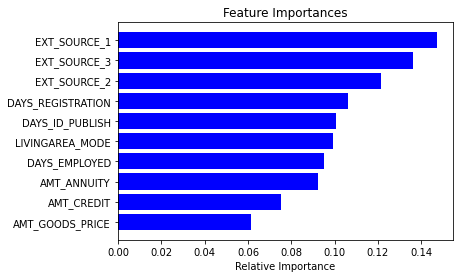

In [9]:
if __name__ == "__main__":
    pain(debug=debug, dropMissingValues=dropMissingValues, savePlots = savePlots, outlierThreshold = 3)
    if debug == True:
        debugFd.write("Module Completed...\n")
        debugFd.write(lineString+"\n")
        debugFd.close()